# Analyse des données de santé pour l'année 2016

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

# Paramètres des plots

In [2]:
SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize

# 1. Données honoraires

In [3]:
file = '/home/alba/MSBigData2019/INFMDI721Kitdatasc/data/Honoraires_totaux_des_professionnels_de_sante_par_departement_en_2016.xls'

df = pd.read_excel(file, sheet_name='Spécialistes')

columns = ['Spécialistes',
           'DEPARTEMENT',
           'EFFECTIFS',
           'HONORAIRES SANS DEPASSEMENT (Euros)',
           'DEPASSEMENTS (Euros)']

df = df[columns]
df.head()

,Spécialistes,DEPARTEMENT,EFFECTIFS,HONORAIRES SANS DEPASSEMENT (Euros),DEPASSEMENTS (Euros)
0,02- Anesthésie-réanimation chirurgicale,01- Ain,17,4.53008e+06,2.49618e+06
1,02- Anesthésie-réanimation chirurgicale,02- Aisne,19,4.98526e+06,373838
2,02- Anesthésie-réanimation chirurgicale,03- Allier,19,5.1029e+06,560979
3,02- Anesthésie-réanimation chirurgicale,04- Alpes-Hte-Provence,4,nc,nc
4,02- Anesthésie-réanimation chirurgicale,05- Hautes-Alpes,5,nc,nc


## Nettoyage des données

In [4]:
df_clean = df.copy()
df_clean = df_clean.rename(index=str, columns={"Spécialistes": "SPECIALISTES",
                                    "HONORAIRES SANS DEPASSEMENT (Euros)": "HONORAIRES",
                                    "DEPASSEMENTS (Euros)": "DEPASSEMENTS"})

# Supprime les valeurs non connues ou égales à 0
df_clean = df_clean.loc[df_clean['DEPASSEMENTS'] != 'nc']
df_clean = df_clean.loc[df_clean['HONORAIRES'] != 'nc']
df_clean = df_clean.loc[df_clean['EFFECTIFS'] != 0]

# Cast dépassement et honoraires en float
df_clean['DEPASSEMENTS'] = df_clean['DEPASSEMENTS'].astype(str).astype(float)
df_clean['HONORAIRES'] = df_clean['HONORAIRES'].astype(str).astype(float)

# Nettoyage 'SPECIALISTES' et 'DEPARTEMENT'
df_clean['SPECIALISTES'] = df_clean['SPECIALISTES'].str.replace(r'\d+', '') \
                          .str.replace(r'^[\s]', '') \
                          .str.replace(r'[^\w\s]', '').map(lambda x: x.strip())
df_clean['DEPARTEMENT'] = df_clean['DEPARTEMENT'].str.replace(r'\(.*\)','').map(lambda x: x.strip())



In [5]:
# Prise en compte des départements qui commencent par des chiffres uniquement
filter = df_clean['DEPARTEMENT'].str.contains(r'[\d]')
df_clean = df_clean[filter]
filter = df_clean['SPECIALISTES'].str.contains(r'TOTAL(.*)')
df_clean = df_clean[~filter]

/home/alba/miniconda3/envs/MY_ENV_P37/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  after removing the cwd from sys.path.


In [6]:
df_clean = df_clean.sort_values(by=['DEPARTEMENT', 'DEPASSEMENTS'],  ascending=[True, False])
df_clean.head()

,SPECIALISTES,DEPARTEMENT,EFFECTIFS,HONORAIRES,DEPASSEMENTS
3640,Ophtalmologie,01- Ain,20,6992462.82,2530891.60
0,Anesthésieréanimation chirurgicale,01- Ain,17,4530079.33,2496180.45
1664,Radiodiagnostic et imagerie médicale,01- Ain,39,17403976.84,2374782.05
2184,Gynécologie obstétrique,01- Ain,16,2973058.99,1149660.54
4992,Chirurgie orthopédique et traumatologie,01- Ain,12,1903402.86,1010938.75


# 2. Données population

In [7]:
file = '/home/alba/MSBigData2019/INFMDI721Kitdatasc/data/estim-pop-dep-sexe-gca-1975-2018.xls'
df_population = pd.read_excel(file, sheet_name='2016', skiprows=4)
df_population.head()

,Unnamed: 0,Unnamed: 1,0 à 19 ans,20 à 39 ans,40 à 59 ans,60 à 74 ans,75 ans et plus,Total,0 à 19 ans.1,20 à 39 ans.1,40 à 59 ans.1,60 à 74 ans.1,75 ans et plus.1,Total.1,0 à 19 ans.2,20 à 39 ans.2,40 à 59 ans.2,60 à 74 ans.2,75 ans et plus.2,Total.2
0,01,Ain,167021,147968,177879,94794,50205,637867,85701,74232,88712,46157,19966,314768,81320,73736,89167,48637,30239,323099
1,02,Aisne,136884,118130,144590,89115,48704,537423,69972,59041,71769,42779,17841,261402,66912,59089,72821,46336,30863,276021
2,03,Allier,71186,64721,92025,68089,44764,340785,36354,32647,45208,32178,17008,163395,34832,32074,46817,35911,27756,177390
3,04,Alpes-de-Haute-Provence,34812,30191,44532,32653,19626,161814,18113,15040,21758,15916,7957,78784,16699,15151,22774,16737,11669,83030
4,05,Hautes-Alpes,31451,28715,39451,26042,15538,141197,16068,14469,19616,12678,6250,69081,15383,14246,19835,13364,9288,72116


## Nettoyage des données

In [8]:
columns = ['Unnamed: 0',
            'Unnamed: 1',
            'Total',
            '20 à 39 ans.2',
            '40 à 59 ans.1']

df_population = df_population[columns]
df_population_clean = df_population.copy()
df_population_clean = df_population_clean.rename(index=str, columns={"Unnamed: 0": "DEPARTEMENT_NUM", 
                                                                     "Unnamed: 1": "DEPARTEMENT_NOM",
                                                                     "Total": "POPULATION",
                                                                     "20 à 39 ans.2": "femmes_20-39",
                                                                     "40 à 59 ans.1": "hommes_40-59"})
df_population_clean['DEPARTEMENT'] = df_population_clean['DEPARTEMENT_NUM'].astype(str) + '- ' + df_population_clean['DEPARTEMENT_NOM'].astype(str)
df_population_clean.head()

,DEPARTEMENT_NUM,DEPARTEMENT_NOM,POPULATION,femmes_20-39,hommes_40-59,DEPARTEMENT
0,01,Ain,637867,73736,88712,01- Ain
1,02,Aisne,537423,59089,71769,02- Aisne
2,03,Allier,340785,32074,45208,03- Allier
3,04,Alpes-de-Haute-Provence,161814,15151,21758,04- Alpes-de-Haute-Provence
4,05,Hautes-Alpes,141197,14246,19616,05- Hautes-Alpes


## Merge des données honoraires et population

In [9]:
df_clean = df_clean.merge(df_population_clean, on='DEPARTEMENT')
df_clean = df_clean.drop(columns=['DEPARTEMENT_NUM', 'DEPARTEMENT_NOM'])

# Création d'une variable ID_SPECIALITE pour regrouper les spécialités
df_clean = df_clean.assign(ID_SPECIALITE=(df_clean['SPECIALISTES']).astype('category').cat.codes)

# Création d'un ratio de dépassements
df_clean['RATIO_DEPASSEMENTS'] = df_clean['DEPASSEMENTS'] / (df_clean['DEPASSEMENTS'] + df_clean['HONORAIRES'])

# Création d'un ratio de dépassements / effectifs (de médecins)
df_clean['RATIO_DEPASSEMENTS_EFFECTIFS'] = df_clean['RATIO_DEPASSEMENTS'] / df_clean['EFFECTIFS']

col = ['DEPARTEMENT','SPECIALISTES','ID_SPECIALITE', 'EFFECTIFS', 'RATIO_DEPASSEMENTS_EFFECTIFS','POPULATION','femmes_20-39']
df_clean = df_clean[col]
df_clean.head()

,DEPARTEMENT,SPECIALISTES,ID_SPECIALITE,EFFECTIFS,RATIO_DEPASSEMENTS_EFFECTIFS,POPULATION,femmes_20-39
0,01- Ain,Ophtalmologie,25,20,0.013288,637867,73736
1,01- Ain,Anesthésieréanimation chirurgicale,1,17,0.020898,637867,73736
2,01- Ain,Radiodiagnostic et imagerie médicale,32,39,0.003079,637867,73736
3,01- Ain,Gynécologie obstétrique,14,16,0.017429,637867,73736
4,01- Ain,Chirurgie orthopédique et traumatologie,4,12,0.028907,637867,73736


## Commentaire

La table ci-dessus va nous servir pour l'étude des questions 1, 2 et 3.

# 3. Données tranche d'âge

In [10]:
file = '/home/alba/MSBigData2019/INFMDI721Kitdatasc/data/estim-pop-dep-sexe-aq-1975-2018.xls'
df_population_age = pd.read_excel(file, sheet_name='2016', skiprows=4)

## Présentation des données

In [11]:
df_population_age_clean = df_population_age.copy()
df_population_age_clean = df_population_age_clean.rename(index=str, columns={"Unnamed: 0": "DEPARTEMENT_NUM", 
                                                                     "Unnamed: 1": "DEPARTEMENT_NOM",
                                                                     "0 à 4 ans": "0-4",
                                                                     "65 à 69 ans": "65-69",
                                                                     "70 à 74 ans": "70-74",
                                                                     "75 à 79 ans": "75-79",
                                                                     "80 à 84 ans": "80-84",
                                                                     "85 à 89 ans": "85-89",
                                                                     "90 à 94 ans": "90-94",                                                                     
                                                                     "95 ans et plus":"95-"})

df_population_age_clean.head()

,DEPARTEMENT_NUM,DEPARTEMENT_NOM,0-4,5 à 9 ans,10 à 14 ans,15 à 19 ans,20 à 24 ans,25 à 29 ans,30 à 34 ans,35 à 39 ans,...,55 à 59 ans.2,60 à 64 ans.2,65 à 69 ans.2,70 à 74 ans.2,75 à 79 ans.2,80 à 84 ans.2,85 à 89 ans.2,90 à 94 ans.2,95 ans et plus.2,Total.2
0,01,Ain,39758.0,44566.0,43975.0,38722.0,29573.0,35715.0,40599.0,42081.0,...,20403.0,18715.0,17961.0,11961.0,9811.0,9138.0,6776.0,3625.0,889.0,323099.0
1,02,Aisne,32675.0,35227.0,35718.0,33264.0,25933.0,29856.0,31343.0,30998.0,...,18491.0,18377.0,17885.0,10074.0,10005.0,9833.0,6966.0,3441.0,618.0,276021.0
2,03,Allier,15882.0,18048.0,19039.0,18217.0,14895.0,15488.0,16997.0,17341.0,...,12431.0,13274.0,13417.0,9220.0,8568.0,8677.0,6461.0,3244.0,806.0,177390.0
3,04,Alpes-de-Haute-Provence,7815.0,8764.0,9523.0,8710.0,6265.0,7178.0,8285.0,8463.0,...,6067.0,5800.0,6323.0,4614.0,3871.0,3416.0,2596.0,1436.0,350.0,83030.0
4,05,Hautes-Alpes,7177.0,8234.0,8547.0,7493.0,5880.0,6762.0,7819.0,8254.0,...,5012.0,5129.0,4881.0,3354.0,3009.0,2740.0,2011.0,1186.0,342.0,72116.0


## Merge des données population âge et honoraires

In [12]:
# Création d'une variable 'DEPARTEMENT' pour le merge
df_population_age_clean['DEPARTEMENT'] = df_population_age_clean['DEPARTEMENT_NUM'].astype(str) + '- ' + df_population_age_clean['DEPARTEMENT_NOM'].astype(str)

# Création de variables 'bebe' (0-4) et 'vieux' (on regroupe tous les âges au delà de 65 ans)
df_population_age_clean['bebe'] = df_population_age_clean['0-4']
df_population_age_clean['vieux'] = df_population_age_clean['65-69'] + df_population_age_clean['70-74'] \
                                  + df_population_age_clean['75-79'] + df_population_age_clean['80-84'] \
                                  + df_population_age_clean['85-89'] + df_population_age_clean['90-94'] \
                                  + df_population_age_clean['95-']

df_population_age_clean = df_population_age_clean.merge(df_clean, on='DEPARTEMENT')
df_population_age_clean['ratio_effectif_bebe'] =  df_population_age_clean['EFFECTIFS'] / df_population_age_clean['bebe'] 
df_population_age_clean['ratio_effectif_vieux'] =  df_population_age_clean['EFFECTIFS'] / df_population_age_clean['vieux']
df_population_age_clean['ratio_effectif_femmes_20-39'] =  df_population_age_clean['EFFECTIFS'] / df_population_age_clean['femmes_20-39']
#df_population_age_clean['ratio_effectif_hommes_40-59'] =  df_population_age_clean['EFFECTIFS'] / df_population_age_clean['hommes_40-59']

col = ['DEPARTEMENT','ID_SPECIALITE', 'EFFECTIFS', 'bebe', 'ratio_effectif_bebe', 'vieux','ratio_effectif_vieux','femmes_20-39','ratio_effectif_femmes_20-39']
df_population_age_clean = df_population_age_clean[col]
df_population_age_clean.head()

,DEPARTEMENT,ID_SPECIALITE,EFFECTIFS,bebe,ratio_effectif_bebe,vieux,ratio_effectif_vieux,femmes_20-39,ratio_effectif_femmes_20-39
0,01- Ain,25,20,39758.0,0.000503,108092.0,0.000185,73736,0.000271
1,01- Ain,1,17,39758.0,0.000428,108092.0,0.000157,73736,0.000231
2,01- Ain,32,39,39758.0,0.000981,108092.0,0.000361,73736,0.000529
3,01- Ain,14,16,39758.0,0.000402,108092.0,0.000148,73736,0.000217
4,01- Ain,4,12,39758.0,0.000302,108092.0,0.000111,73736,0.000163


## Commentaire

La table ci-dessus va nous servir pour l'étude de la question 3.

# 4. Analyse des données

## Q1: Peut-on établir un lien entre la densité de médecins par spécialité  et par territoire et la pratique du dépassement d'honoraires ?

Pour répondre à cette question, je me suis intéressée au taux de dépassement d'honaires en tenant compte des effectifs de medecins par spécialité et par territoire. Afin d'avoir une vue d'ensemble, j'ai commencé par tracer l'évolution du ratio de depassement d'honoraires en fonction des effectifs des médecins. J'ai ensuite décidé de tracer des histogrammes par spécialité  représentant le taux de dépassement d'honoraire par département. Seuls les graphes pour 3 des spécialités sont représentés ici. Ensuite, j'ai voulu voir le top 5 des spécialités qui pratiquent le plus de dépassement d'honaires et dans quel département cela a lieu.

In [13]:
# Mapping des spécialités à leur variable catégorique
dict_specialites = dict(enumerate((df_clean['SPECIALISTES']).astype('category').cat.categories))

# Regroupement par région et par spécialité
col = ['RATIO_DEPASSEMENTS_EFFECTIFS']

# Ratio de dépassement d'honoraires par densité de médecin par spécialité et par territoire
df_a1 = df_clean.groupby(['ID_SPECIALITE','DEPARTEMENT'])[col].min()

In [14]:
df_clean.head()

,DEPARTEMENT,SPECIALISTES,ID_SPECIALITE,EFFECTIFS,RATIO_DEPASSEMENTS_EFFECTIFS,POPULATION,femmes_20-39
0,01- Ain,Ophtalmologie,25,20,0.013288,637867,73736
1,01- Ain,Anesthésieréanimation chirurgicale,1,17,0.020898,637867,73736
2,01- Ain,Radiodiagnostic et imagerie médicale,32,39,0.003079,637867,73736
3,01- Ain,Gynécologie obstétrique,14,16,0.017429,637867,73736
4,01- Ain,Chirurgie orthopédique et traumatologie,4,12,0.028907,637867,73736


(0, 209)

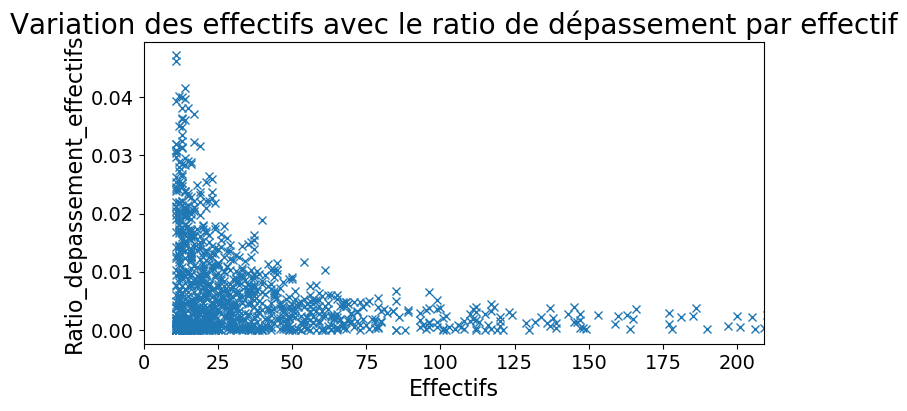

In [28]:
plt.figure(figsize=(8,4), dpi=100) #10 unites dans un sens, 4 dans l'autre
plt.plot(df_clean['EFFECTIFS'], df_clean['RATIO_DEPASSEMENTS_EFFECTIFS'], 'x')

plt.xlabel('Effectifs')
plt.ylabel('Ratio_depassement_effectifs')
plt.title("Variation des effectifs avec le ratio de dépassement par effectif")
plt.xlim([0, 209])

### Commentaire

Moins il y a d'effectifs de médecins et plus ils pratiquent de dépassement d'honoraires. En revanche ce graphe ne fait pas intervenir la composante spécialité, qui s'avère être très importante quand au niveau de pratique des dépassements d'honoraires. D'où la création des histogrammes ci-dessous.

### Histogrammes

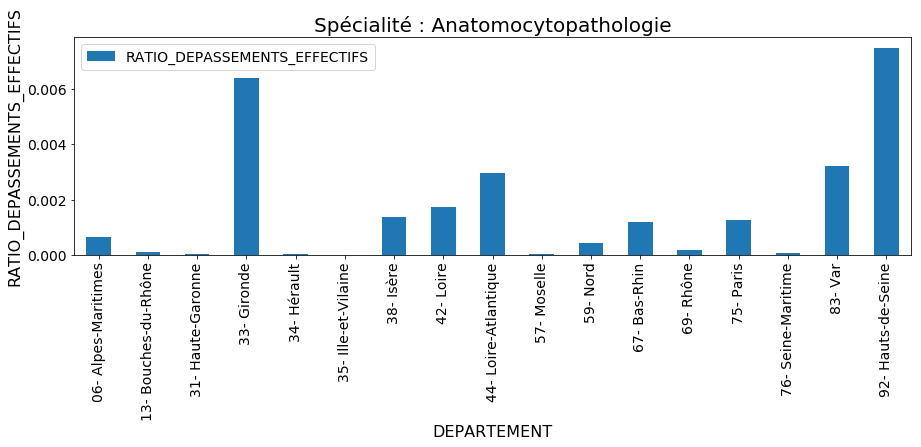

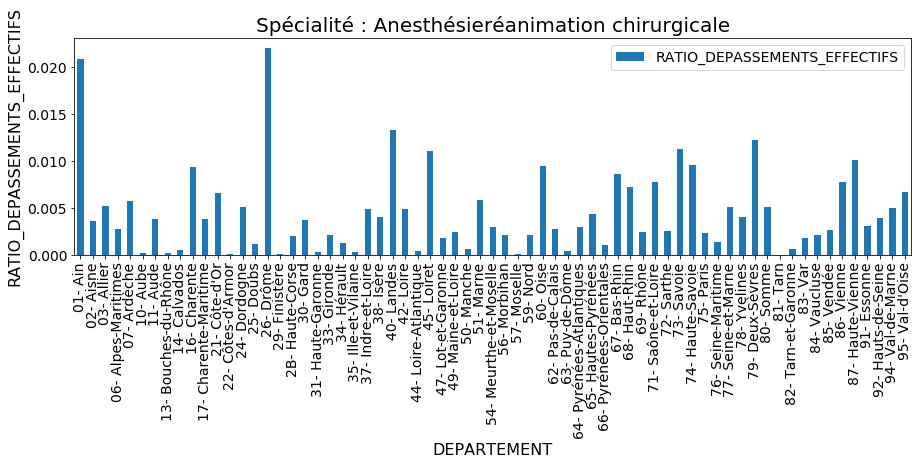

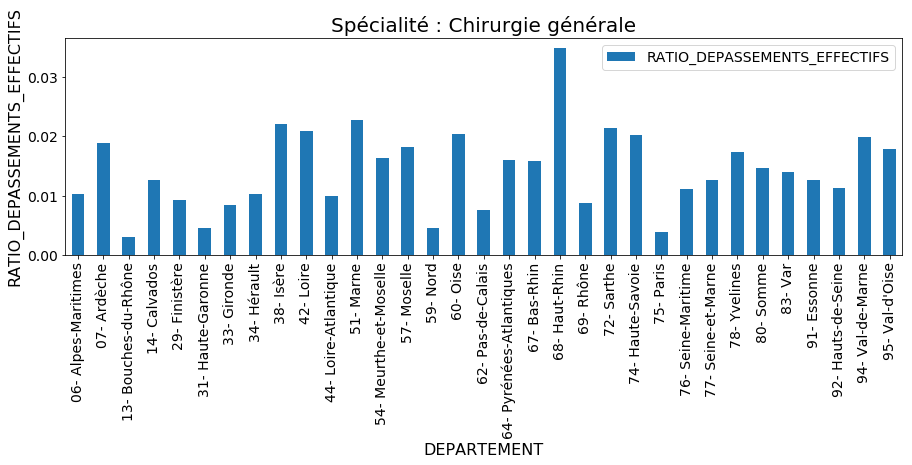

In [20]:
# Histogramme du ratio de dépassement pour les 3 premières spécialités
for k in range(3):
    df_a1.loc[k].plot.bar(figsize=(15,4))    
    plt.title(f'Spécialité : {dict_specialites[k]}')
    plt.ylabel('RATIO_DEPASSEMENTS_EFFECTIFS')

### TOP 5 des spécialités pratiquant les plus hauts taux de dépassement

In [21]:
col = ['RATIO_DEPASSEMENTS_EFFECTIFS']

# Indice des valeurs max pour le ratio de dépassements / effectifs (de médecins) 
list_idx = df_clean.groupby(['ID_SPECIALITE'])[col].idxmax().values.tolist()

idx_max_ratio = [elmnt[0] for elmnt in list_idx] 

col = ['DEPARTEMENT', 'EFFECTIFS', 'SPECIALISTES', 'RATIO_DEPASSEMENTS_EFFECTIFS']
df_max_ratio_depassement = df_clean[col].iloc[idx_max_ratio,:]

df_max_ratio_depassement = df_max_ratio_depassement.sort_values(by=['RATIO_DEPASSEMENTS_EFFECTIFS'],  ascending=[False])
df_max_ratio_depassement.head()


,DEPARTEMENT,EFFECTIFS,SPECIALISTES,RATIO_DEPASSEMENTS_EFFECTIFS
392,38- Isère,11,Chirurgie plastique reconstructrice et esthétique,0.047145
707,68- Haut-Rhin,11,Chirurgie urologique,0.046156
829,75- Paris,12,Psychiatrie de lenfant et de ladolescent,0.040113
1081,95- Val-d'Oise,13,Stomatologie,0.039979
738,69- Rhône,14,Chirurgie maxillofaciale et stomatologie,0.039690


### Commentaire
On constate que l'Isère pratique le plus de dépassement d'honoraire par densité de médecin (en chirurgie plastique, ce qui ne paraît pas étonnant).

## Q2: Est-ce  dans les territoires où la densité est la plus forte que les médecins  pratiquent le moins les dépassement d'honoraires?
Pour répondre à cette question, j'ai commencé par faire une moyenne des dépassements d'honoraires pratiqués dans chaque département. J'ai ensuite tracé sur un histogramme cette moyenne calculée ainsi que la population du département.

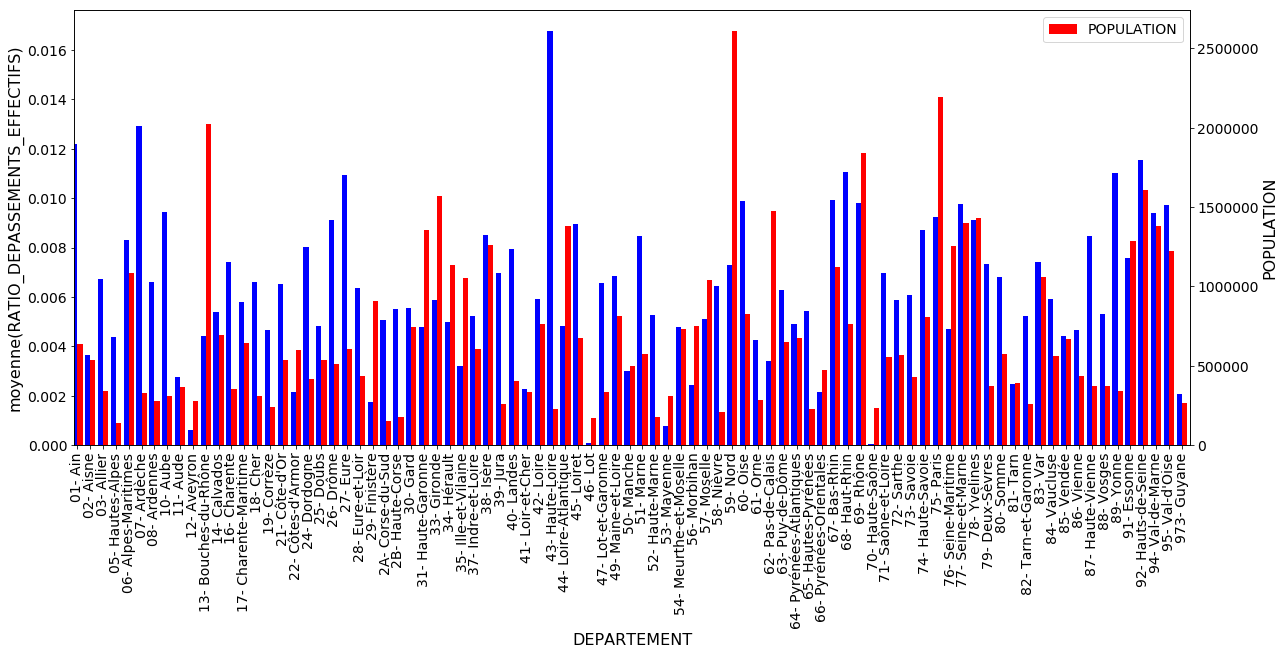

In [22]:
df_a21 = df_clean.groupby(['DEPARTEMENT'])['RATIO_DEPASSEMENTS_EFFECTIFS'].mean()
df_a22 = df_clean.groupby(['DEPARTEMENT'])['POPULATION'].max()

fig = plt.figure(figsize=(20,8)) # Create matplotlib figure
ax = fig.add_subplot(111) # Create matplotlib axes
ax2 = ax.twinx() # Create another axes that shares the same x-axis as ax.
width = 0.4
df_a21.plot(kind='bar', color='blue', ax=ax, width=width, position=1, label='RATIO_DEPASSEMENTS_EFFECTIFS')
df_a22.plot(kind='bar', color='red', ax=ax2, width=width, position=0, label='POPULATION')
ax.set_ylabel('moyenne(RATIO_DEPASSEMENTS_EFFECTIFS)')
ax2.set_ylabel('POPULATION')
plt.legend()
plt.show()

## Commentaire
On constate que le Nord ou Paris (départements les plus peuplés) pratiquent un taux de dépassement d'honoraire moins important que des départements bien moins peuplés comme la Haute-Loire ou le Haut-Rhin.

## Q3: Est ce que la densité de certains médecins / praticiens est corrélée à la densité de population pour certaines classes d'ages (bebe/pediatre, personnes agées / infirmiers etc...) ?

Pour cette question, je me suis intéréssée à 3 classes de personnes:
- les bébés
- les personnes âgées (vieux)
- les femmes en âge de procréer.

J'ai voulu tout d'abord voir si les régions qui avaient les plus hauts taux de pédiatres par bébé étaient aussi celles où il y avaient le plus de bébés. J'ai en ai fait de même pour la classe personnes âgées et la spécialité pathologie cardiovasculaire, puis la classe femme en âge de procréer et gynécologie obstétrique.

In [23]:
# Regroupement par région et par spécialité
df_a31 = df_population_age_clean.groupby(['ID_SPECIALITE','DEPARTEMENT'])['ratio_effectif_bebe'].max()
df_a32 = df_population_age_clean.groupby(['ID_SPECIALITE','DEPARTEMENT'])['bebe'].max()

df_a41 = df_population_age_clean.groupby(['ID_SPECIALITE','DEPARTEMENT'])['ratio_effectif_vieux'].max()
df_a42 = df_population_age_clean.groupby(['ID_SPECIALITE','DEPARTEMENT'])['vieux'].max()

df_a51 = df_population_age_clean.groupby(['ID_SPECIALITE','DEPARTEMENT'])['ratio_effectif_femmes_20-39'].max()
df_a52 = df_population_age_clean.groupby(['ID_SPECIALITE','DEPARTEMENT'])['femmes_20-39'].max()


In [24]:
dict_specialites

{0: 'Anatomocytopathologie',
 1: 'Anesthésieréanimation chirurgicale',
 2: 'Chirurgie générale',
 3: 'Chirurgie maxillofaciale et stomatologie',
 4: 'Chirurgie orthopédique et traumatologie',
 5: 'Chirurgie plastique reconstructrice et esthétique',
 6: 'Chirurgie thoracique et cardiovasculaire',
 7: 'Chirurgie urologique',
 8: 'Chirurgie vasculaire',
 9: 'Chirurgie viscérale et digestive',
 10: 'Dermatovénéréologie',
 11: 'Endocrinologie et métabolisme',
 12: 'Gastroentérologie et hépatologie',
 13: 'Gynécologie médicale',
 14: 'Gynécologie obstétrique',
 15: 'Gynécologie obstétrique et gynécologie médicale',
 16: 'Médecine Physique et de Réadaptation',
 17: 'Médecine interne',
 18: 'Médecine nucléaire',
 19: 'Neurochirurgie',
 20: 'Neurologie',
 21: 'Neuropsychiatrie',
 22: 'Néphrologie',
 23: 'Oncologie médicale',
 24: 'Oncologie radiothérapique',
 25: 'Ophtalmologie',
 26: 'Otorhinolaryngologie',
 27: 'Pathologie cardiovasculaire',
 28: 'Pneumologie',
 29: 'Psychiatrie',
 30: 'Psych

## Bébés

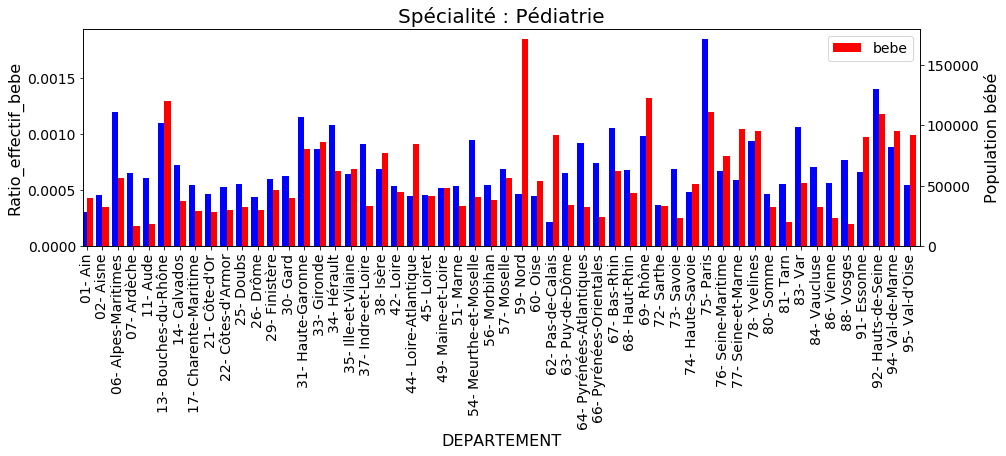

In [25]:
k = 31
fig = plt.figure(figsize=(15,4)) # Create matplotlib figure

ax = fig.add_subplot(111) # Create matplotlib axes
ax2 = ax.twinx() # Create another axes that shares the same x-axis as ax.

width = 0.4

df_a31.loc[k].plot(kind='bar', color='blue', ax=ax, width=width, position=1, label='ratio_effectif_bebe')
df_a32.loc[k].plot(kind='bar', color='red', ax=ax2, width=width, position=0, label='bebe')
ax.set_ylabel('Ratio_effectif_bebe')
ax2.set_ylabel('Population bébé')
plt.title(f'Spécialité : {dict_specialites[k]}')    
plt.legend()
plt.show()

### Commentaire
Cet histogramme montre que  dans certains département comme le Nord, il y a beaucoup de bébés pour très peu de pédiatres, alors qu'à Paris c'est l'inverse. La répartition pédiatre vs nombre de bébés n'est pas très équilibrée.

## Vieux

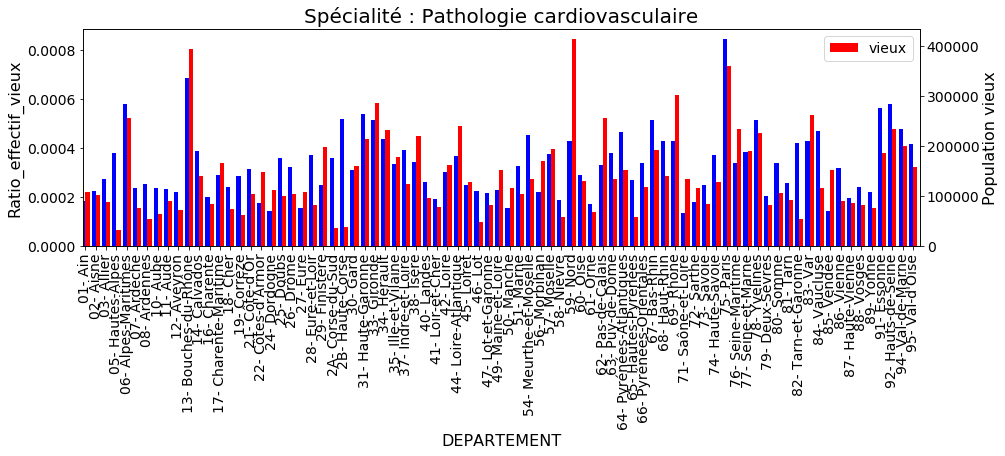

In [26]:
k = 27
fig = plt.figure(figsize=(15,4)) # Create matplotlib figure

ax = fig.add_subplot(111) # Create matplotlib axes
ax2 = ax.twinx() # Create another axes that shares the same x-axis as ax.

width = 0.4

df_a41.loc[k].plot(kind='bar', color='blue', ax=ax, width=width, position=1, label='ratio_effectif_vieux')
df_a42.loc[k].plot(kind='bar', color='red', ax=ax2, width=width, position=0, label='vieux')
ax.set_ylabel('Ratio_effectif_vieux')
ax2.set_ylabel('Population vieux')
plt.title(f'Spécialité : {dict_specialites[k]}')    
plt.legend()
plt.show()

### Commentaire
Cet histogramme montre que la répartition spécialiste en pathologie cardiovasculaire vs nombre de personnes agées est relativement bien équilibrée (à quelque départements prés). Dans les régions où l'on a peu de personnes âgées, il y a moins de spécialistes alors qu'il y en a plus dans les régions avec plus de personnes âgées.

## Femmes 20-39 ans

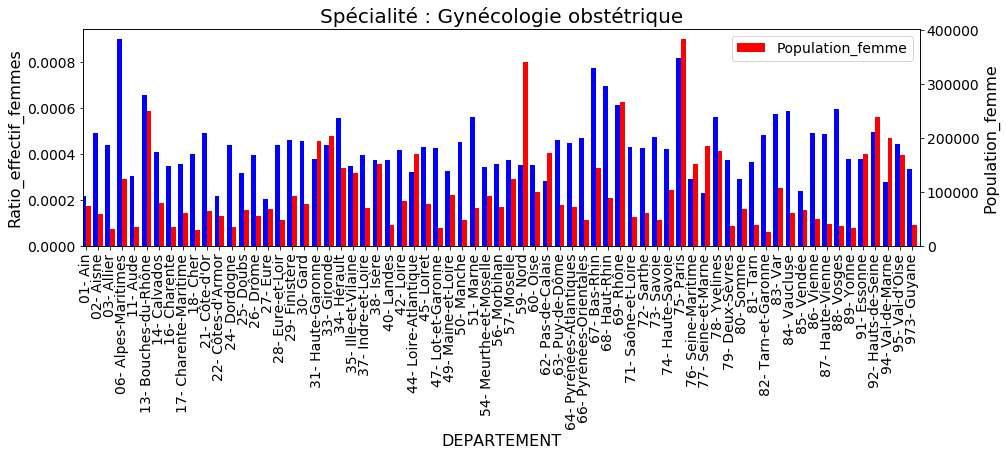

In [27]:
k = 14
fig = plt.figure(figsize=(15,4)) # Create matplotlib figure

ax = fig.add_subplot(111) # Create matplotlib axes
ax2 = ax.twinx() # Create another axes that shares the same x-axis as ax.

width = 0.4

df_a51.loc[k].plot(kind='bar', color='blue', ax=ax, width=width, position=1, label='Ratio_effectif_femmes')
df_a52.loc[k].plot(kind='bar', color='red', ax=ax2, width=width, position=0, label='Population_femme')
ax.set_ylabel('Ratio_effectif_femmes')
ax2.set_ylabel('Population_femme')
plt.title(f'Spécialité : {dict_specialites[k]}')    
plt.legend()
plt.show()

### Commentaire
Pour avoir un enfant, il vaut mieux aller dans les Alpes Maritimes que dans le Nord, où il y a le plus de gynécologues obstétriques et une faible population de femmes en âges de procréer.

### Conclusion
Il n'existe pas forcément une très bonne balance entre le nombre de médécins aptes à traiter certaines pathologies et la densité de population sujette à avoir ces pathologies.